In [ ]:
# default_exp model_functions

# Model Functions

> Endowing networkx MultiDiGraph objects with dynamics, calculating the resulting timeseries, and visualizing and analyzing the data.

In [ ]:
#hide
from nbdev import *
from nbdev.imports import *
from nbdev.export import *
from nbdev.sync import *
from nbdev.showdoc import *

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
#export
import warnings
with warnings.catch_warnings(): #ignore warnings
    warnings.simplefilter("ignore")
    import networkx as nx
    import numpy as np
    import sidis
    from sidis import XOR,NOT,COPY
    rng=sidis.RNG(0)
    import matplotlib.pyplot as plt
    import typing
    from typing import Optional, Tuple, Dict, Callable, Union, Mapping, Sequence, Iterable, Hashable, List, Any
    from collections import namedtuple
    
    from networkm.graph_functions import *

In [ ]:
#export
def sigmoid(x : Union[int,float,np.ndarray],
            a : Union[int,float,np.ndarray] = np.inf):
    '''
    Sigmoid function; returns [1 + tanh( a*(x-0.5) )] / 2.
    When `a`=np.inf, mimics np.rint function.
    When `a`=0, returns constant 0.5.
    When `a`=1, returns `x`.
    When `a`>1, smoothly approaches np.rint.
    Faster than the np.rint and round functions,
    due to the order of operations on temporary variable `A`.
    Note edge case x=0.5 returns np.nan when a=np.inf.
    '''
    A=x-0.5
    A*=a
    A=np.tanh(A)
    A+=1.
    A/=2.
    return A

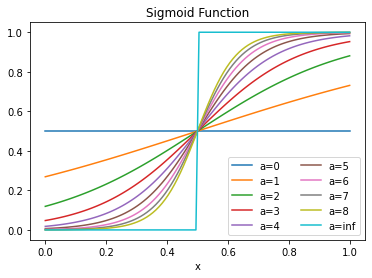

In [ ]:
for a in list(range(0,9))+[np.inf]:
    x=np.linspace(0,1,100)
    plt.plot(x,sigmoid(x=x,a=a),label=f'a={a}')
    plt.legend(loc='lower right', ncol=2)
    plt.title('Sigmoid Function')
    plt.xlabel('x')

In [ ]:
#export
def graph_iter(G : nx.MultiDiGraph,
             graph_keys : Union[str,List[str]] ='predecessors',
             edge_keys : Union[str,List[str]] = 'delay',
             node_keys : Union[str,List[str]] = 'a',
             views='in',
             zipit=True
            ) -> List[List[Union[tuple,np.ndarray,np.ndarray]]]:
    '''
    Construct a list of iterables used in the calculation
    of a delay-differential-equation (dde) for a network `G`.
    Returns a list-of-lists containing  [(node_start,node_stop), 
    adjacency_matrix, delay_matrix, node constants] for each 
    group of nodes sharing the same in-degree.
    '''
    graph_keys = sidis.cast(graph_keys,list)
    node_keys = sidis.cast(node_keys,list)
    edge_keys = sidis.cast(edge_keys,list)
    views = sidis.cast(views,list)
    res={'slice':[]}
    
    for key in graph_keys+node_keys+edge_keys:
        res.update({key:[]})
    
    node_index=0
    for deg,nodes in G.sorting.items():
        if deg==0:
            pass
        else:
            L=len(nodes)
            res['slice']+=[(node_index,node_index+L)]
            
            for key in graph_keys:
                res[key]+=[np.array([list(sidis.get(G,key,n)) for n in nodes])]
            
            for key in node_keys:
                res[key]+=[np.array([G.nodes[n][key] for n in nodes]).reshape((L,1))]
                
            for view,key in zip(views,edge_keys):
                if view=='in':
                    edges=G.in_edges
                elif view=='out':
                    edges=G.out_edges
                res[key]+=[np.array([G.edges[e][key] 
                                     for e in edges(nodes,keys=True)]).reshape((L,deg))]
            node_index+=L
    if not zipit:
        return res
    else:
        keys=list(res.keys())
        values=list(zip(*list(res.values())))
        tup=namedtuple('iter',keys)
        res=[tup(*value) for value in values]
        return res

In [ ]:
g=nx.MultiDiGraph()
g.add_edges_from([('a','c'),('b','a'),('b','b'),('c','b'),('c','c'),('d','c')])
give_edges(g,{e:dict(delay=i) for i,e in enumerate(g.edges)})
give_nodes(g,a=10)
convert_edges(g,
              edges=None,
              lengths=1,
              node_data={'a':1},
              label=lambda g,node,iterable : str(node)+'_'+str(iterable+1),
              delay=0
             )
sort_graph(g,relabel=True)
graph_iter(g,zipit=True)

[iter(slice=(0, 1), predecessors=array([[3, 5, 6]]), a=array([[10]]), delay=array([[0, 5, 2]])),
 iter(slice=(1, 2), predecessors=array([[4, 6]]), a=array([[10]]), delay=array([[4, 1]])),
 iter(slice=(2, 7), predecessors=array([[4],
        [2],
        [1],
        [7],
        [0]]), a=array([[10],
        [ 1],
        [ 1],
        [ 1],
        [ 1]]), delay=array([[3],
        [0],
        [0],
        [0],
        [0]]))]

In [ ]:
graph_iter(g,zipit=False)

{'slice': [(0, 1), (1, 2), (2, 7)],
 'predecessors': [array([[3, 5, 6]]),
  array([[4, 6]]),
  array([[4],
         [2],
         [1],
         [7],
         [0]])],
 'a': [array([[10]]),
  array([[10]]),
  array([[10],
         [ 1],
         [ 1],
         [ 1],
         [ 1]])],
 'delay': [array([[0, 5, 2]]),
  array([[4, 1]]),
  array([[3],
         [0],
         [0],
         [0],
         [0]])]}

In [ ]:
#export
def dde_derivative(t : int,
                   x : List[float],
                   dx : List[float],
                   f : List[callable],
                   tau : List[Union[float,List[float]]],
                   epsilon : List[float],
                   iterator : List[Union[tuple,list]]):
    '''
    Delay-differential-equation derivative of the form
    dxdt=[-x(t)+sigmoid([f(sigmoid(y)) for y in in_nodes(x)])+noise]/time_constant.
    Uses an iterator grouping the parameters by in-degree to accelerate calculation.
    '''
    for (n1,n2),predecessors,node_constants,delays in iterator:
        y=x[t-delays,predecessors]
        y=sigmoid(x=y,a=node_constants)
        y=sigmoid(x=np.array([F(*y[j]) for j,F in enumerate(f[n1:n2])]))
        dx[n1:n2]=y
    return (-x[t]+dx+epsilon)/tau

In [ ]:
#export
def dde_derivative_risefall(t : int,
                   x : List[float],
                   dx : List[float],
                   f : List[callable],
                   tau : List[Union[float,List[float]]],
                   epsilon : List[float],
                   iterator : List[Union[tuple,list]]):
    '''
    Delay-differential-equation derivative of the form
    dxdt=[-x(t)+sigmoid([f(sigmoid(y)) for y in in_nodes(x)])+noise]/time_constant.
    Uses an iterator grouping the parameters by in-degree in order to accelerate.
    Uses two time-constants for the rise and fall behavior, based on current state.
    '''
    for (n1,n2),predecessors,node_constants,delays in iterator:
        y=sigmoid(x=x[t-delays,predecessors],a=node_constants)
        dx[n1:n2]=sigmoid(np.array([F(*y[j]) for j,F in enumerate(f[n1:n2])]))
    return (-x[t]+dx+epsilon)/(tau[:,0]+(tau[:,1]-tau[:,0])*sigmoid(x[t]))

In [ ]:
#export
@sidis.timer
def dde_integrator(dt : float,
                   T : int,
                   initial_conditions : List[float], 
                   hold_times : List[int],
                   f : List[callable],
                   tau : List[Union[float,List[float]]],
                   epsilon : float,
                   iterator : List[Union[tuple,list]]):

    '''
    Euler integrator for delay-differential-equation with noise.
    Uses network model parameters and includes a 
    `forcing_matrix` which sets the initial conditions
    and any other time-dependent forcing functions not
    included in the derivative.
    Infers the maximum time delay and hold times for the initial
    conditions, then integrates in two blocks. In the first block,
    the initial conditions are applied, and in the second,
    the derivative is calculated normally.
    The derivative is chosen based on the shape of the node constants `tau`.
    '''
    initial_conditions = np.array(initial_conditions)
    hold_times = (np.array(hold_times)/dt).astype(int)
    T = int(T/dt)
    #get max time delays and hold times
    max_delay=int(np.max([np.max(i.delay) for i in iterator]))
    max_hold=np.max(hold_times)
    
    #setup memory for node states and noise
    x = np.zeros((T,len(initial_conditions)))
    epsilon=rng.normal(x=0,y=epsilon,shape=x.shape)
    dx=np.zeros(x.shape[1])
    
    #infer if there is a changing rise/fall time
    if len(tau.shape)!=1:
        deriv=dde_derivative_risefall
    else:
        deriv=dde_derivative
    
    #integrate with forced initial conditions
    for t in range(max([max_delay,max_hold])):
        holds=np.ravel(np.argwhere(hold_times>=t))
        x[t,holds]=initial_conditions[holds]
        dxdt=deriv(t=t,x=x,dx=dx,f=f,tau=tau,epsilon=epsilon[t],iterator=iterator)
        x[t+1]=x[t]+dt*dxdt
    
    #integrate freely
    for t in range(max_hold,T-1):
        dxdt=deriv(t=t,x=x,dx=dx,f=f,tau=tau,epsilon=epsilon[t],iterator=iterator)
        x[t+1]=x[t]+dt*dxdt
        
    return x

dde_integrator : Elapsed time: 0.0471 seconds


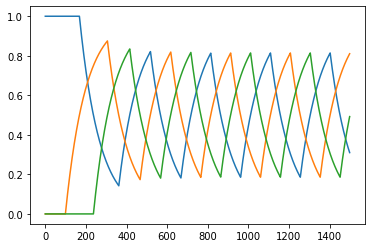

In [ ]:
g=nx.MultiDiGraph()
g=ring(N=3,left=True,right=False,loop=False)
give_edges(g,delay=0)
give_nodes(g,a=10,tau=1,f=NOT)
sort_graph(g,relabel=True)

x=dde_integrator(dt=0.01,
                 T=15,
                 initial_conditions = [1,0,0],
                 hold_times = [1,1,1],
                 f = node_data(g)['f'],
                 tau = node_data(g)['tau'],
                 epsilon = 0,
                 iterator = graph_iter(g))

for i in range(len(g)):
    plt.plot(x[:,i])

dde_integrator : Elapsed time: 0.0461 seconds


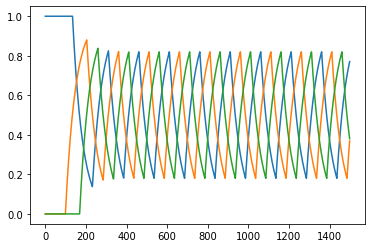

In [ ]:
g=nx.MultiDiGraph()
g=ring(N=3,left=True,right=False,loop=False)
give_edges(g,delay=0)
give_nodes(g,a=10,tau=0.5,f=NOT)
sort_graph(g,relabel=True)

x=dde_integrator(dt=0.01,
                 T=15,
                 initial_conditions = [1,0,0],
                 hold_times = [1,1,1],
                 f = node_data(g)['f'],
                 tau = node_data(g)['tau'],
                 epsilon = 0,
                 iterator = graph_iter(g))

for i in range(len(g)):
    plt.plot(x[:,i])

In [ ]:
g=ring(N=3,left=True,right=False,loop=False)
give_edges(g,delay=0)
give_nodes(g,a=10,tau=1,f=NOT)
print_graph(g)
convert_edges(g,lengths=1,node_data=dict(a=10,tau=1,f=COPY),delay=0)

|Node|Predecessors|Successors|
|0   |1           |2         |
|1   |2           |0         |
|2   |0           |1         |



In [ ]:
sort_graph(g,relabel=True)
print_graph(g)

|Node|Predecessors|Successors|
|0   |4           |3         |
|1   |5           |4         |
|2   |3           |5         |
|3   |0           |2         |
|4   |1           |0         |
|5   |2           |1         |



dde_integrator : Elapsed time: 0.0521 seconds


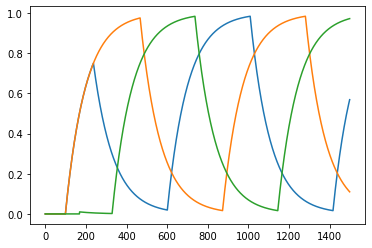

In [ ]:
x=dde_integrator(dt=0.01,
                 T=15,
                 initial_conditions = [0,0,0]+[1,0,0],
                 hold_times = [1,1,1]+[1,1,1],
                 f = node_data(g)['f'],
                 tau = node_data(g)['tau'],
                 epsilon = 0,
                 iterator = graph_iter(g))

for i in range(3):
    plt.plot(x[:,i])

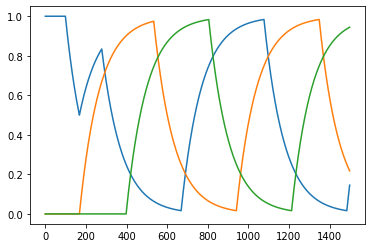

In [ ]:
for i in range(3,6):
    plt.plot(x[:,i])

dde_integrator : Elapsed time: 0.2582 seconds


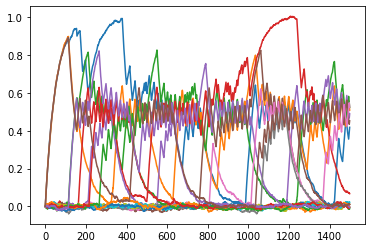

In [ ]:
N=16
g=ring(N=N,left=True,right=True,loop=True)
give_edges(g,delay=0)
give_nodes(g,a=20,tau=0.5,f=XOR)
convert_edges(g,lengths=1,node_data=dict(a=20,tau=0.2,f=COPY),delay=0)
sort_graph(g,relabel=True)

x=dde_integrator(dt=0.01,
                 T=15,
                 initial_conditions = [0 if i!=N else 1 for i in range(2*N)],
                 hold_times = [0 for i in range(N)]+[1 for i in range(N,2*N)],
                 f = node_data(g)['f'],
                 tau = node_data(g)['tau'],
                 epsilon = 0.1,
                 iterator = graph_iter(g))

for i in range(N):
    plt.plot(x[:,i])

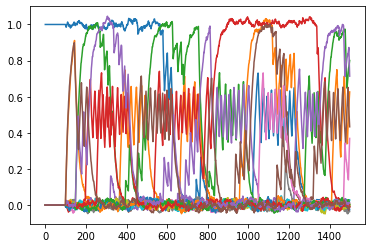

In [ ]:
for i in range(16,32):
    plt.plot(x[:,i])

In [ ]:
#export
def parse_initial_conditions(g,
                             initial_conditions : Optional[List] = None,
                             hold_times : Optional[List] = None,
                             mpx_nodes : Optional[List] = None
                            ):
    '''
    Parse the initial conditions of the network, including the node states
    and holding times (times for which the nodes are forced to the initial state).
    If there are multiplexer nodes, the initial conditions are applied only to these
    nodes, and the rest are allowed to freely integrate without any hold time.
    If there are not multiplexer nodes, the initial condition is transformed
    according to the boolean function of each node. For example, a one-node network
    that executes the NOT of itself would have the initial condition [0] be transformed
    into [1]. This mimics the real behavior of the network in hardware with multiplexers.
    '''
    
    if mpx_nodes:
        original_nodes = [i for i in g.nodes if i not in mpx_nodes]
        if initial_conditions is None: #default to 1 logic high node
            initial_conditions = [1]+[0 for i in mpx_nodes[1:]]

        #set original nodes to 0
        initial_conditions=np.array([0 for i in original_nodes]+initial_conditions)

        if hold_times is None: #default to hold time of 1 for mpxs
            hold_times = [1 for i in mpx_nodes]

        #don't hold non-mpxs
        hold_times = np.array([0 for i in original_nodes]+hold_times)

    else: #not mpx model; need to transform challenge
        if initial_conditions is None: #default to 1 node logic high
            initial_conditions = [1]+[0 for i in range(len(g)-1)]

        #transform challenge by evaluating boolean func
        initial_conditions=np.array([g.nodes[n]['f'](*[initial_conditions[j] \
              for j in list(g.predecessors(n))]) for n in g.nodes])

        #default to hold time of 1
        if hold_times is None: 
            hold_times = np.array([1 for i in g.nodes])

    return initial_conditions,hold_times

In [ ]:
g=ring()
give_nodes(g,f=NOT)
parse_initial_conditions(g)

(array([1, 1, 0]), array([1, 1, 1]))

In [ ]:
g=ring()
give_nodes(g,f=NOT)
convert_edges(g,node_data=dict(f=COPY))
parse_initial_conditions(g,mpx_nodes=where(g,f=COPY))

(array([0, 0, 0, 1, 0, 0]), array([0, 0, 0, 1, 1, 1]))

In [ ]:
#export
def plot_graph(g,
          graph_iter : List[tuple],
          x : List[float],
          dt : float = 0.01,
          reset : bool = False,
          X : float = 5,
          Y : float = 3.5,
          hspace : float = 0,
          offset : float = 1,
          font : str = 'sans-serif',
          fontsize : int = 12,
          ticksize : int = 6,
          tickwidth : int = 2,
          linewidth : int = 2):
    '''
    Make separate plots of the node states `x` for each in-degree grouping.
    '''
    sidis.figParams(reset,X,Y,hspace,offset,font,fontsize,ticksize,tickwidth,linewidth)
    for group in graph_iter:
        nodes=group.slice
        for i in range(*nodes):
            plt.plot(np.arange(x.shape[0])*dt,x[:,i])
            title=f'In-Degree {g.in_degree(nodes[0])}: Nodes {nodes[0]} to {nodes[1]-1}'
            plt.title(title)
            plt.xlabel('Time (ns)')
            plt.ylabel('Amplitude')
        plt.show()

In [ ]:
#export
def graph_model( g = ring(N=16,right=True,left=True,loop=True),
                 T = 15,
                 dt = 0.01,
                 epsilon = 0,
                 initial_conditions = None,
                 hold_times = None,
                 node_attrs = dict(
                     a = (rng.normal,20,0),
                     tau = (rng.normal,0.5,0),
                     f = XOR
                 ),
                 edge_attrs = dict(
                     delay = (rng.random,0,0),
                 ),
                 convert_attrs = dict(
                     lengths = 1,
                     delay = (rng.normal,0,0),
                     node_attrs = dict(
                         a = (rng.normal,20,0),
                         tau = (rng.normal,0.2,0),
                         f = COPY
                     ),
                     label = lambda g,node,iterable : len(g)+iterable
                 )
               ):
        '''
        Model the dynamics of the graph by ascribing the given node and edge
        attributes, and converting any edges with the given conversion attrs.
        Returns the node state array and plots the resulting dynamics.
        
        Parameters:
            g : incoming graph data
            T : integration time
            dt : integration timestep
            epsilon : noise amplitude; positive-definite uniformly random
            node_data : dict containing
                a : node sigmoid parameter, use np.inf for rounding
                tau : node time constant, use scalar for single time constant,
                    or tuple (rise,fall) for rise and fall behavior
                f : node boolean function
            edge_data : dict containing
                delay : time-delay along the given edge
                replace : None for no edge replacement,
                    or a dict containing:
                        lengths : number of replacement nodes along each edge,
                        use lengths=1 for a multiplexer model.
                        node attributes of the new nodes replacing that edge,
                        delay : time delays along new edges
                        label : node names of new nodes
        '''
        
        t2i = lambda t: (np.array(t)/dt).astype(int)
        
        #give node/edge attrs
        give_nodes(g,data=node_attrs,nodes=g.nodes,**node_attrs)
        give_edges(g,data=edge_attrs,edges=g.edges,**edge_attrs)
        
        #flag for changing challenge behavior
        mpx_nodes=None
        original_nodes = list(g.nodes)
        
        #convert edges to new nodes
        if convert_attrs:
            convert_edges(g,edges=convert_attrs.get('edges'),
                               lengths=convert_attrs.get('lengths'),
                               node_data=convert_attrs.get('node_attrs'),
                               delay=convert_attrs.get('delay'))
            
            #if replacing with multiplexers
            if convert_attrs['lengths']==1:
                mpx_nodes=[n for n in g.nodes if n not in original_nodes]
        
        #transform delays to int        
        for e in g.edges:
            g.edges[e]['delay']=t2i(g.edges[e]['delay'])
        
        #save new data
        nodedata=node_data(g)
        edgedata=edge_data(g)
        
        #sort graph
        sort_graph(g,relabel=True)

        #get iterable
        graphiter = graph_iter(g,graph_keys='predecessors',edge_keys='delay',node_keys='a')
        
        #transform initial conditions
        IC,HT=parse_initial_conditions(g=g,initial_conditions=initial_conditions,
                                       hold_times=hold_times,mpx_nodes=mpx_nodes)
        
        #integrate
        x=dde_integrator(dt=dt,
                         T=T,
                         initial_conditions = IC,
                         hold_times = HT,
                         f = nodedata['f'],
                         tau = nodedata['tau'],
                         epsilon = epsilon,
                         iterator = graphiter)
        
        #plot
        plot_graph(g=g,x=x,dt=dt,graph_iter=graphiter)
        
        return x

dde_integrator : Elapsed time: 0.2436 seconds


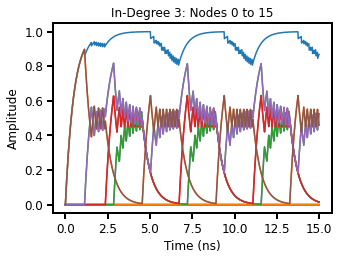

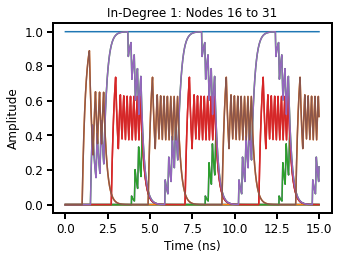

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.00000000e-02, 2.00000000e-02, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.96000000e-02, 3.96000000e-02, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [8.63442530e-01, 4.78113256e-01, 5.06233204e-01, ...,
        6.11625591e-05, 1.34085344e-01, 5.64646761e-01],
       [8.66173680e-01, 4.68550991e-01, 5.16108540e-01, ...,
        5.81044312e-05, 1.77381077e-01, 5.36414423e-01],
       [8.68850206e-01, 4.59179971e-01, 5.25786369e-01, ...,
        5.51992096e-05, 2.18512023e-01, 5.09593702e-01]])

In [ ]:
graph_model()

In [ ]:
notebook2script()

Converted 00_graph_functions.ipynb.
Converted 01_model_functions.ipynb.
Converted 02_network_class.ipynb.
Converted index.ipynb.
